In [2]:
# Bibliotecas Importadas
import geopandas as gpd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from shapely.geometry import Point, Polygon
import os
from osgeo import gdal

#######################################################################################################

# Carregando arquivos do tipo shapefile
# Pontos -> São os pontos com valores conhecidos de altitudes
# lim -> Limite da área

pontos = gpd.read_file('C:/Users/User/Desktop/TCC\Clickgeo/Dados_pratica8_9_Qgis/ptos_cotados_clip.shp')
lim = gpd.read_file('C:/Users/User/Desktop/TCC/Clickgeo/Dados_pratica8_9_Qgis/bacia_ariranha.shp')

# Conferindo o sistema de referência de coordenadas, deve retornar True ou deverá ser reprojetado

print(pontos.crs == lim.crs)

# Acessando o DataFrame com os dados de pontos

pontos.head(3)

True


,FID_,Entity,Layer,Color,Linetype,Elevation,LineWt,RefName,Angle,geometry
0,0,Insert,PONTE,5,CONTINUOUS,1314.790039,25,COD109,232.0,POINT Z (327469.370 7586167.580 1314.790)
1,0,Insert,PONTE,5,CONTINUOUS,1313.589966,25,COD109,75.0,POINT Z (327487.750 7586160.380 1313.590)
2,0,Insert,PONTE,5,CONTINUOUS,1288.189941,25,COD109,331.0,POINT Z (328027.540 7586439.650 1288.190)


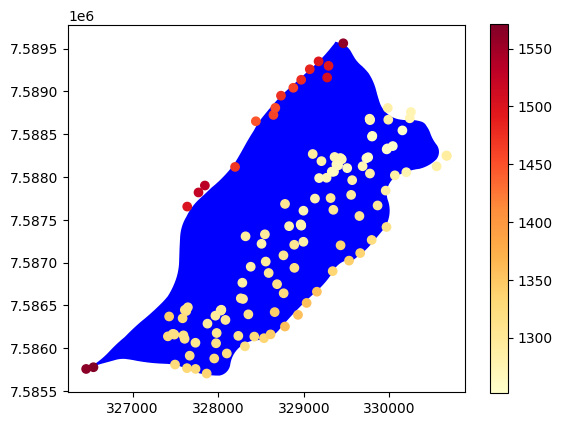

[ 326457.64 7585705.37  330670.7  7589562.6 ]
mínima coordenada de x: 326457.64
máxima coordenada de x: 330670.7
mínima coordenada de y: 7585705.37
máxima coordenada de y: 7589562.6


In [3]:
########################################################################################################

# Plotando mapa com o limite da área e os pontos

fig,ax = plt.subplots()
lim.plot(color = 'blue', ax=ax)
pontos.plot(column = 'Elevation', ax=ax, legend = 'True', cmap = 'YlOrRd') #Legenda colorida com degrade
plt.show()

#########################################################################################################

# Acessando os dados do DataFrame para os processamentos posteriores.

x = pontos['geometry'].x ##Latitude
y = pontos['geometry'].y ##Longitude
z = pontos['Elevation'] ## Elevação

########################################################################################################

# total_bounds atributo é usado para pegar os máximos e mínimos das coordenadas de x e y na seguinte ordem: 
# (minx, miny, maxx, maxy)

print(pontos.total_bounds)

# Atribuindo variáveis dentro da lista de dados do total bounds aos valores mínimos e máximos

minx, miny, maxx, maxy = pontos.total_bounds
print(f"mínima coordenada de x: {minx}\nmáxima coordenada de x: {maxx}\nmínima coordenada de y: {miny}\nmáxima coordenada de y: {maxy}")

In [4]:
# Criando um Array para os valores do eixo X utilizando arange da numpy

grid_de_x = np.arange(minx - 10,maxx + 10, 10, dtype='float64')
#grid_de_x

# Criando um Array para os valores do eixo Y utilizando arange da numpy

grid_de_y = np.arange(miny - 10, maxy + 10, 10, dtype='float64')
#grid_de_y

# Criando Grid de coordenadas com meshgrid da numpy

xi, yi = np.meshgrid(grid_de_x, grid_de_y)

##########################################################################################################################

# Acessando valores no Grid de coordenadas e criando uma lista de tuplas com as respectivas coordenadas
lista_de_tuplas = []
for x, y in np.nditer([xi,yi]):  # Iterando o Grid x e y
    lista_de_tuplas.append((x,y)) # Adicionando cada elemento x e y em uma tupla, correspondendo às coordenadas do grid

# Acessando valores dentro da lista de tuplas e atribuindo às listas com os respectivos valores de latitude e longitude

Latitude = []
Longitude = []
for i in lista_de_tuplas:
    Latitude.append(i[0]) # Buscando elementosna posição zero (Latitude) da lista de tuplas e adicionando em uma nova lista de floats
    Longitude.append(i[1]) # Buscando elementosna posição um (Longitude) da lista de tuplas e adicionando em uma nova lista de floats

In [5]:
############################ Trabalhando para iniciar a interpolação de valores baseando-se nos cálculos de distâncias com GeoPandas ###########################

################################################################################################################################################################

# Criando um DataFrame Pandas no braço com colunas de Latitude, Longitude a efeito de visualização

df = {'Latitude': Latitude,
      'Longitude': Longitude}

df = pd.DataFrame(df)

################################################################################################################################################################

# Aplicando a classe Point() do módulo shapely.geometry que cria uma geometria de duas dimensões (ponto) e permite realizar processamentos com essas geometrias

pontos_geometricos = [Point(i) for i in lista_de_tuplas] # Laço for pythonico 
# Equivaleria a um:
# for i in lista de tuplas:
    # pontos_geometricos = Point(i)

geo_dados = gpd.GeoDataFrame(df, crs='EPSG:31983', geometry=pontos_geometricos) # OBS: TENHO QUE FAZER ALGO PARA EPSG SER SEMPRE IGUAL AO DOS PONTOS.
geo_dados

,Latitude,Longitude,geometry
0,326447.64,7585695.37,POINT (326447.640 7585695.370)
1,326457.64,7585695.37,POINT (326457.640 7585695.370)
2,326467.64,7585695.37,POINT (326467.640 7585695.370)
3,326477.64,7585695.37,POINT (326477.640 7585695.370)
4,326487.64,7585695.37,POINT (326487.640 7585695.370)
...,...,...,...
164507,330637.64,7589565.37,POINT (330637.640 7589565.370)
164508,330647.64,7589565.37,POINT (330647.640 7589565.370)
164509,330657.64,7589565.37,POINT (330657.640 7589565.370)
164510,330667.64,7589565.37,POINT (330667.640 7589565.370)


In [6]:
################################################################################################################################################################

# Deixando Sistema de Coordenadas iguais para não haver erro nos cálculos das distâncias e na plotagem..
# Como os pontos são de POÇOS DE CALDAS - MG, o sistema mais adequado é o EPSG:31983 SIRGAS 2000, PROJEÇÃO UTM, ZONA 23S

################################################################################################################################################################

# Atribuindo o lim e o pontos a um novo epsg

lim = lim.to_crs(epsg = 31983)
pontos = pontos.to_crs(epsg = 31983)

# Verificando, se retornar True, estão toods no mesmo sistema de coordenadas

lim.crs == pontos.crs == geo_dados.crs

True

In [7]:
# Agora de fato irei aplicar os cálculos e gerar uma coluna com os valores obtidos para cada coordenada

# Para efetuar os cálculos utilizarei função anônima, ou função lambda para deixar o código mais enxuto e pythonico
# A caráter de melhor compreensão

# geo_dados['geometry'].apply(lambda x: pontos.distance(x).min())

# Na colune de pontos geométricos em geo_dados, é aplicada uma função em cada linha a qual calcula a distancia de cada ponto do DataFrame pontos (pontos. distance), 
# Encontra o índice índice da menor distância (idxmin), ou seja, o ponto no DataFrame pontos que há a menor distância da linha em questão, com esse índice em mãos,
# É localizado o valor de Elevation neste exato índice atráves do iloc.
# Dessa forma, os valores_interpolados correspondem aos valores de elevação que apresentam a menor distância de cada coordenada do grid, implementando assim,
# A interpolação dos vizinhos mais próximos!

valores_interpolados = geo_dados['geometry'].apply(lambda x: pontos['Elevation'].iloc[pontos.distance(x).idxmin()])


# Adicionando a coluna com os valores interpolados no DataFrame geo_dados
geo_dados['Elev. Interp'] = valores_interpolados

KeyboardInterrupt: 

In [ ]:
def obter_elevacao_mais_proxima(x):
    distancia_minima_indice = pontos.distance(x).idxmin()
    return pontos['Elevation'].iloc[distancia_minima_indice]

testando_valores = geo_dados['geometry'].apply(obter_elevacao_mais_proxima)
np.array_equal(testando_valores, valores_interpolados)

True

In [ ]:
import tcc

In [ ]:
coordx = tcc.series_para_array(geo_dados['geometry'].x)
coordy = tcc.series_para_array(geo_dados['geometry'].y)

inerpolando = tcc.interp_media_dos_pontos(coordx, coordy, pontos)

c:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
c:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
c:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\User\AppData\Local\Prog

KeyboardInterrupt: 

In [ ]:
geo_dados

,Latitude,Longitude,geometry,Elev. Interp
0,326447.64,7585695.37,POINT (326447.640 7585695.370),1564.933960
1,326457.64,7585695.37,POINT (326457.640 7585695.370),1564.933960
2,326467.64,7585695.37,POINT (326467.640 7585695.370),1571.520996
3,326477.64,7585695.37,POINT (326477.640 7585695.370),1571.520996
4,326487.64,7585695.37,POINT (326487.640 7585695.370),1571.520996
...,...,...,...,...
164507,330637.64,7589565.37,POINT (330637.640 7589565.370),1275.733032
164508,330647.64,7589565.37,POINT (330647.640 7589565.370),1275.733032
164509,330657.64,7589565.37,POINT (330657.640 7589565.370),1275.733032
164510,330667.64,7589565.37,POINT (330667.640 7589565.370),1275.733032


In [ ]:
# Aqui fiz o cálculo da distância mínima de cada coordenada do grid para um ponto conhecido.
geo_dados['geometry'].apply(lambda x: pontos.distance(x).min())

0          39.473721
1          48.584279
2          48.898722
3          43.358265
4          39.607996
             ...    
164507    954.158078
164508    958.725214
164509    963.374503
164510    968.104763
164511    972.914811
Name: geometry, Length: 164512, dtype: float64

In [ ]:
# criando um grid com as dimensões da imagem e atribuindo a uma variável grid_valores para plotagem com imshow

grid_valores = valores_interpolados.values.reshape(388,424)

In [ ]:
inerpolando = np.array(inerpolando)
grid_valores = inerpolando.reshape(388,424)

In [ ]:
pontos.head()

,FID_,Entity,Layer,Color,Linetype,Elevation,LineWt,RefName,Angle,geometry
0,0,Insert,PONTE,5,CONTINUOUS,1314.790039,25,COD109,232.0,POINT Z (327424.257 7586122.134 1314.790)
1,0,Insert,PONTE,5,CONTINUOUS,1313.589966,25,COD109,75.0,POINT Z (327442.637 7586114.934 1313.590)
2,0,Insert,PONTE,5,CONTINUOUS,1288.189941,25,COD109,331.0,POINT Z (327982.427 7586394.204 1288.190)
3,0,Insert,PONTE,5,CONTINUOUS,1288.189941,25,COD109,135.0,POINT Z (327992.067 7586404.744 1288.190)
4,0,Insert,PONTE,5,CONTINUOUS,1270.030029,25,COD109,257.0,POINT Z (329281.299 7588018.107 1270.030)


In [ ]:
criar_elipse = tcc.cria_poligono_elipse(327992.067,7586404.744,1500,700)
elipse = gpd.GeoSeries(criar_elipse, crs = 31983)

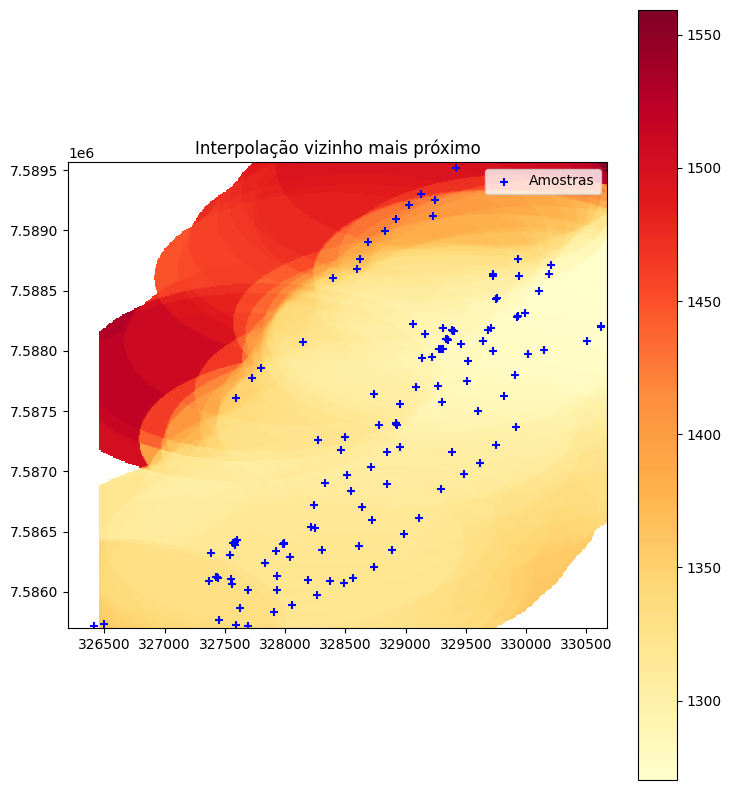

In [ ]:
# Plotagem utilizando matplotlib

fig,ax = plt.subplots(figsize = (8,10))

cax = ax.imshow(grid_valores, extent=(minx-5, maxx+5, miny-5, maxy+5), origin="lower", cmap="YlOrRd")

pontos.plot(color="blue", ax=ax, marker="+", label="Amostras")

cbar=plt.colorbar(cax, fraction = 0.08)
#elipse.plot(color="blue", ax=ax,)
ax.legend()
plt.title("Interpolação vizinho mais próximo")

plt.show()

#########################################################################################################################################

Transformando para csv e para tif

In [ ]:
dfn = { 'X': geo_dados['Latitude'],
       'Y': geo_dados['Longitude'], 
       'Z': geo_dados['Elev. Interp']
}
dfn = pd.DataFrame(dfn)
dfn.head()

,X,Y,Z
0,326447.64,7585695.37,1564.933960
1,326457.64,7585695.37,1564.933960
2,326467.64,7585695.37,1571.520996
3,326477.64,7585695.37,1571.520996
4,326487.64,7585695.37,1571.520996


In [ ]:
# Transformando dfn em csv

dfn.to_csv("dfn.xyz", index = False, header = None, sep = " ")

# Transformando csv em tif

demn = gdal.Translate("teste.tif", "dfn.xyz", outputSRS = "EPSG:31983")
demn = None

def toTIFF(dfn, name):
    dfn.to_csv(name+".xyz", index = False, header = None, sep = " ")
    demn = gdal.Translate(name+".tif", name+".xyz", outputSRS = "EPSG:31983", 
                          xRes = res, yRes = -res)

########################################################################################################################################################

In [ ]:
import tcc
elipse = tcc.cria_poligono_elipse(2,1,2,1)
tilezinho = Point(4.1,1)
type(elipse)

shapely.geometry.polygon.Polygon

False

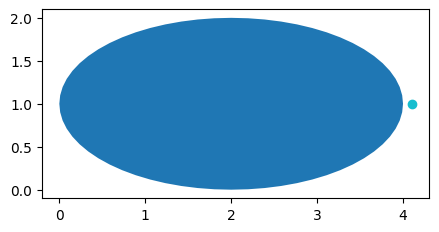

In [ ]:
g = gpd.GeoSeries([elipse, tilezinho])
g.plot(cmap='tab10',figsize=(5,5))
elipse.intersects(tilezinho)

In [ ]:
pontos['geometry'][84].intersects(geo_dados['geometry'][4])

False